In [1]:
import torch
import yaml
import time
import numpy as np
from pathlib import Path
from torch.utils.data import DataLoader
from torch_ema import ExponentialMovingAverage

from models.state_mlp import StateMLP
from data.lasa_data import StatePyLASADataset, wrap
from utils.plotting import *
from utils.manifold_utils import *

from flow_matching.utils.manifolds import Manifold, Sphere, Euclidean
from flow_matching.path import GeodesicProbPath
from flow_matching.path.scheduler import CondOTScheduler

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from soft_dtw import *
import os
from tqdm import tqdm
from typing import Dict, Any

Using LASA DataSet from /home/stanislav/anaconda3/envs/ml_env/lib/python3.12/site-packages/pyLasaDataset/resources/LASAHandwritingDataset/DataSet


In [2]:
torch.manual_seed(3420934659826)

In [3]:
run_parameters =  yaml.safe_load(Path("./configs/tangent_3D.yaml").read_text())
run_parameters

{'train': {'lr': 0.0001,
  'epochs': 100001,
  'batch_size': 100,
  'inf_every': 4000,
  'print_every': 4000,
  'device': 'cpu',
  'inf_runs_num': 1,
  'inf_run_step': 0.05},
 'model': {'hidden_dim': 96, 'num_layers': 6, 'embed_dim': 24},
 'data': {'dim': 3,
  'manifold': 'Sphere',
  'datasets': ['Sine'],
  'horizon_size': 20,
  'inference_horizon': 10,
  'scale_factor': 2.0,
  'downsample': 5,
  'sample_points': 220,
  'mean': 0.0,
  'std': 0.5},
 'ema': {'warmup': 2000, 'update': 5, 'decay': 0.999},
 'scheduler': {'step': 10000, 'gamma': 0.5}}

In [4]:
manifold_types = {'None' : None, 'Euclidean': Euclidean(), 'Sphere':Sphere()}
train_sets= list(range(6)) #+ list(range(7, 13)) + list(range(14, 20)) + list(range(21, 27))
val_sets = [6]#, 13, 20, 27]
print(train_sets, val_sets)

[0, 1, 2, 3, 4, 5] [6]


In [5]:
manifold = manifold_types[run_parameters['data']['manifold']]
LASA_datasets = run_parameters['data']['datasets']

dataset = StatePyLASADataset(LASA_datasets,
                               train=train_sets,
                               horizon_size=run_parameters['data']['horizon_size'],
                               scaling_factor=run_parameters['data']['scale_factor'],
                               downsample = run_parameters['data']['downsample'],
                               manifold=manifold,
                               dim_to=run_parameters['data']['dim'])

print(dataset.__len__())

train_dataset = torch.utils.data.Subset(dataset, train_sets)

test_dataset = torch.utils.data.Subset(dataset, val_sets)

train_dataloader = DataLoader(train_dataset,
                       batch_size=run_parameters['train']['batch_size'],
                       shuffle=True)

val_dataloader = DataLoader(test_dataset,
                    batch_size=run_parameters['train']['batch_size'],
                    shuffle=True)

test_dataloader = DataLoader(test_dataset,
                    batch_size=1,
                    shuffle=False)

inf_obs, _, label = next(iter(test_dataloader))
inf_obs = inf_obs[:, :2]

gt_test = DataLoader(test_dataset,
                    batch_size=4,
                    shuffle=False)

print(test_dataset.__len__())
print(train_dataset.__len__())

gt_obs, gt_horizon, label = next(iter(gt_test))
print(gt_obs.shape)

7
1
6
torch.Size([1, 200, 7])


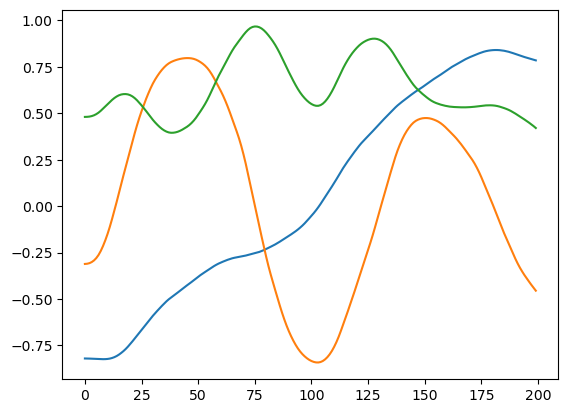

In [6]:
plt.plot(gt_obs[0,:,:3])

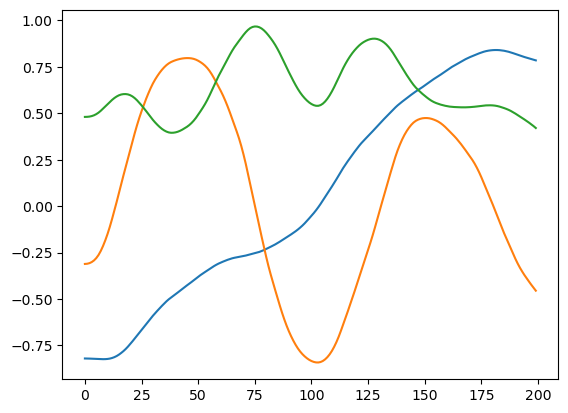

In [7]:
plt.plot(Sphere().expmap(gt_obs[0,0,:3], Sphere().logmap(gt_obs[0,0,:3], gt_obs[0,:,:3])))

In [8]:
def save_config_to_yaml(config: Dict[str, Any], filepath: str) -> None:
    try:
        with open(filepath, 'w') as f:
            yaml.dump(config, f, default_flow_style=False)  
    except Exception as e:
        raise IOError(f"Failed to save config to {filepath}") from e
    
def get_parameters_from_run(run_name):
    return yaml.safe_load(Path(os.path.join('./runs', run_name, 'config.yaml')).read_text())

def get_model(run_name, action_dim=None):
    parameters = get_parameters_from_run(run_name)
    act_dim = action_dim if action_dim is not None else parameters['data']['dim']
    vf = StateMLP(
        action_dim=act_dim,
        hidden_dim=parameters['model']['hidden_dim'],
        horizon_size=parameters['data']['horizon_size'],
        num_layers=parameters['model']['num_layers'],
        label_embedding_dim=parameters['model']['embed_dim'],
        num_classes=len(parameters['data']['datasets'])
    )
    vf.load_state_dict(torch.load(os.path.join("./runs", run_name, "best_model.pth"), weights_only=True))
    return vf

In [9]:
vf = StateMLP(
    action_dim=run_parameters['data']['dim'],
    hidden_dim=run_parameters['model']['hidden_dim'],
    horizon_size=run_parameters['data']['horizon_size'],
    num_layers=run_parameters['model']['num_layers'],
    label_embedding_dim=run_parameters['model']['embed_dim'],
    num_classes=len(LASA_datasets)
)
# vf = get_model("sine_tangent")

ema_vf = ExponentialMovingAverage(
    vf.parameters(),
    decay = run_parameters['ema']['decay'],
)

model_parameters = filter(lambda p: p.requires_grad, vf.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("Learnable params number:", params)

Learnable params number: 84304


In [34]:
normal = sample_normal_source(batch_size=200, dim=2, dim_to=3, manifold=Sphere())

In [35]:
batch = next(iter(train_dataloader))
print(batch[0].shape, batch[1].shape)
gt_obs = batch[0]
a1 = batch[1]
list_traj_original = [gt_obs[i,:,:3] for i in range(6)]
list_traj_tangent = [manifold.logmap(gt_obs[0, 0, :3], gt_obs[i, :, :3]) for i in range(6)]
list_traj_exp = [manifold.expmap(gt_obs[0, 0, :3], list_traj_tangent[i]) for i in range(6)]

torch.Size([6, 200, 7]) torch.Size([6, 200, 20, 3])


In [36]:
normal_proj = manifold.logmap(gt_obs[0, 0, :3], normal[:,0,:])

In [37]:
# plot_3d_points_interactive(list_traj_original)

In [38]:
# plot_3d_points_interactive(list_traj_tangent + [normal_proj])

In [39]:
# plot_3d_points_interactive(list_traj_exp)

In [40]:
# traj_tang = torch.zeros_like(gt_obs)
# traj_tang[:, :, :3] = manifold.logmap(gt_obs[0, 0, :3], gt_obs[:, :, :3])
# traj_tang[:, :, 3:6] = manifold.logmap(gt_obs[0, 0, :3], gt_obs[:, :, 3:6])
# list_traj_tangent = [traj_tang[i, :, 3:6] for i in range(6)]

In [41]:
# hor_tang = torch.zeros_like(a1)
# hor_tang[:,:] = manifold.logmap(gt_obs[0, 0, :3], a1[:, :, :, :3])

In [42]:
# list_hor_tang = []
# for i in range(6):
#     for j in range(200):
#         list_hor_tang.append(hor_tang[i,j])

In [43]:
# plot_3d_points_interactive(list_traj_tangent)

In [44]:
# plot_3d_points_interactive(list_hor_tang)

In [45]:
# run_name = "sine_shape"
# vf.load_state_dict(torch.load(os.path.join("./runs", run_name, "best_model.pth"), weights_only=True))


# ema_vf = ExponentialMovingAverage(
#     vf.parameters(),
#     decay = run_parameters['ema_decay'],
# )
# run_parameters['lr'] = 1e-5
# run_parameters['epochs'] = 30001

In [46]:
# manifold.logmap(gt_obs[0, 0, :3], normal[:]).shape

In [47]:
# plot_3d_points_interactive(list_traj_tangent + [manifold.logmap(gt_obs[0, 0, :3], normal)[:,0,:]])

In [48]:
# obs, a1, label = batch
# start_point = gt_obs[0, 0, :3]

# obs_tang = torch.zeros_like(obs)
# obs_tang[:, :, :3] = manifold.logmap(start_point, obs[:, :, :3])
# obs_tang[:, :, 3:6] = manifold.logmap(start_point, obs[:, :, 3:6])
# obs_tang[:, :, 6:] = obs[:,:,6:]
# a1_tang = manifold.logmap(start_point, a1)

# # print(obs.shape, a1.shape)
# # print(obs_tang.shape, a1_tang.shape)

# label = label.view(-1)
# obs_tang = obs_tang.view(-1, obs.shape[-1])
# a1_tang = a1_tang.view(-1, a1.shape[-2], a1.shape[-1])

# batch_size=a1_tang.shape[0]

# a0 = sample_normal_source(batch_size=batch_size,
#                             dim=2,
#                             horizon=run_parameters['data']['horizon_size'], 
#                             manifold=manifold, 
#                             mean=run_parameters['data']['mean'],
#                             std=run_parameters['data']['std'],
#                             dim_to=run_parameters['data']['dim'])

# a0_tang = manifold.logmap(start_point, a0)

In [49]:
# path = GeodesicProbPath(scheduler=CondOTScheduler(), manifold=Euclidean())
# a0_single = a0_tang[0].unsqueeze(0)
# a1_single = a1_tang[0].unsqueeze(0)
# # t = torch.rand(a0_single.shape[0])
# # t_flat = t.unsqueeze(1).repeat(1, a0_single.shape[1]).view(a0_single.shape[0] * a0_single.shape[1])
# # path_sample = path.sample(t=t_flat, 
# #                             x_0=a0_single.view(a0_single.shape[0]*a0_single.shape[1], a0_single.shape[2]), 
# #                             x_1=a1_single.view(a1_single.shape[0]*a1_single.shape[1], a1_single.shape[2]))
# # x_t = path_sample.x_t.view(a0_single.shape)
# time_steps = torch.linspace(0, 1, steps=11)
# x_t_list = []
# v_t_list = []

# for t in time_steps:
#     t_tensor = torch.full((a0_single.shape[0],), t)
#     t_flat = t_tensor.unsqueeze(1).repeat(1, a0_single.shape[1]).view(-1)

#     path_sample = path.sample(
#         t=t_flat,
#         x_0=a0_single.view(-1, a0_single.shape[2]),
#         x_1=a1_single.view(-1, a1_single.shape[2])
#     )

#     x_t = path_sample.x_t.view(a0_single.shape)
#     v_t = path_sample.dx_t.view(a0_single.shape)
#     x_t_list.append(x_t[0])
#     v_t_list.append(v_t[0])

In [50]:
# plot_3d_points_interactive(x_t_list)

In [51]:
# print(obs_tang.shape)

In [52]:
# list_a1 = [a1_tang[i] for i in range(a1_tang.shape[0])]
# list_a0 = [a0_tang[i] for i in range(a0_tang.shape[0])]
# list_obs_0 = [obs_tang[i][:3].unsqueeze(0) for i in range(1200)]
# list_obs_1 = [obs_tang[i][3:6].unsqueeze(0) for i in range(1200)]


In [53]:
# plot_3d_points_interactive(list_a1 + list_a0)

In [11]:
import torch
import matplotlib.pyplot as plt
import time

def run_train(vf, train_dataloader, 
              val_dataloader, 
              run_parameters, 
              manifold, 
              ema_vf, dataset, 
              gt_obs, 
              run_name, run_path="./runs"):
    save_path = os.path.join(run_path, run_name)
    os.makedirs(save_path, exist_ok=True)
    save_config_to_yaml(run_parameters, os.path.join(save_path, 'config.yaml'))
    
    device = run_parameters['train']['device']
    vf.to(device)

    optim = torch.optim.Adam(vf.parameters(), lr=run_parameters['train']['lr'])
    scheduler = torch.optim.lr_scheduler.StepLR(optim, 
                                               step_size=run_parameters['scheduler']['step'], 
                                               gamma=run_parameters['scheduler']['gamma'])

    path = GeodesicProbPath(scheduler=CondOTScheduler(), manifold=Euclidean())

    train_losses = []
    val_losses = []
    lrs = []
    best_val_loss = float('inf')

    start_time = time.time()
    for i in range(run_parameters['train']['epochs']):
        for batch in train_dataloader:
            optim.zero_grad()

            # print(batch[0].shape, batch[1].shape)

            train_loss = step_tangent(vf=vf, 
                              batch=batch,
                              start_point=gt_obs[0, 0, :3],
                              run_parameters=run_parameters, 
                              manifold=Sphere(),
                              result_vf_manifold=Euclidean(), 
                              path=path, 
                              device=device)
            
            train_loss.backward()
            optim.step()

            if i > run_parameters['ema']['warmup'] and i % run_parameters['ema']['update'] == 0: 
                ema_vf.update()

            if i % run_parameters['train']['print_every'] == 0:
                elapsed = time.time() - start_time
                print('| iter {:6d} | {:5.2f} sec | train loss {:8.3f} '
                      .format(i, elapsed, train_loss.item()))
                
                plt.figure()
                plt.plot(train_losses, label='Training Loss')
                plt.plot(val_losses, label='Validation Loss')
                plt.xlabel('Iterations (x print_every)')
                plt.ylabel('Loss')
                plt.legend()
                plt.savefig(os.path.join(save_path,'loss_plot.png'))
                plt.close()

                plt.figure()
                plt.plot(lrs, label='Learning rate')
                plt.xlabel('Iterations (x print_every)')
                plt.ylabel('lr')
                plt.legend()
                plt.savefig(os.path.join(save_path,'lr_plot.png'))
                plt.close()
                
                with torch.no_grad():
                    ema_vf.store()
                    ema_vf.copy_to()
                    val_batch = next(iter(val_dataloader))
                    loss_val = step_tangent(vf=vf, 
                                            batch=val_batch,
                                            start_point=gt_obs[0, 0, :3],
                                            run_parameters=run_parameters, 
                                            manifold=Sphere(),
                                            result_vf_manifold=Euclidean(), 
                                            path=path, 
                                            device=device)
                    train_losses.append(train_loss.item())
                    val_losses.append(loss_val.item())
                    if loss_val.item() < best_val_loss:
                        best_val_loss = loss_val.item()
                        torch.save(vf.state_dict(), os.path.join(save_path, 'best_model.pth'))
                    print('| iter {:6d} | validation loss: {:8.3f} '.format(i, loss_val.item()))

                    infered = run_inference(manifold=manifold,
                                model=vf,
                                run_parameters=run_parameters,
                                class_labels=dataset.get_label_maping(),
                                gt_obs=gt_obs,
                                inference_type="Tangent")
                    for label_name in infered.keys():
                        # print(infered[label_name]['results'][0].shape)
                        plot_3d_points_interactive([Sphere().expmap(gt_obs[0, 0, :3], infered[label_name]['results'][0])])
                    
                    plt.plot(Sphere().expmap(gt_obs[0, 0, :3], infered[label_name]['results'][0]))
                    plt.show()
                    ema_vf.restore()
                start_time = time.time()
        lrs.append(scheduler.get_last_lr()[0])
        scheduler.step()
        


    vf.load_state_dict(torch.load(os.path.join(save_path,'best_model.pth'), weights_only=True))
    # with torch.no_grad():
    #     infered = run_inference(manifold=manifold,
    #                             model=vf,
    #                             run_parameters=run_parameters,
    #                             class_labels=dataset.get_label_maping(),
    #                             gt_obs=gt_obs)
    #     for label_name in infered.keys():
    #         plot_flow_on_sphere(infered[label_name]['results'], 
    #                             infered[label_name]['samples'], 
    #                             gt_obs[dataset.get_label_maping()[label_name]],
    #                             label=label_name)
    #         plt.savefig(os.path.join(save_path, f'best_model_flow_{label_name}.png'))
    #         plt.close()

| iter      0 |  0.08 sec | train loss    0.810 
| iter      0 | validation loss:    0.887 


Output()

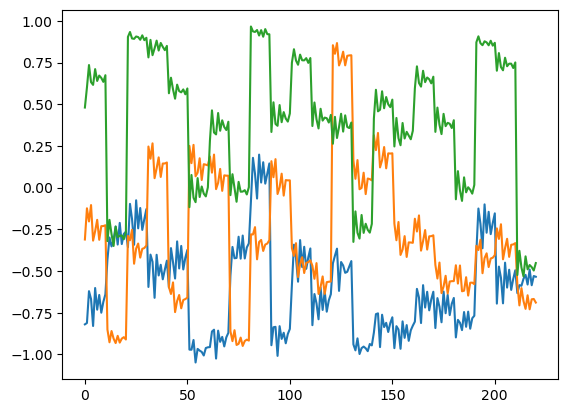

| iter   4000 | 40.07 sec | train loss    0.027 
| iter   4000 | validation loss:    0.032 


Output()

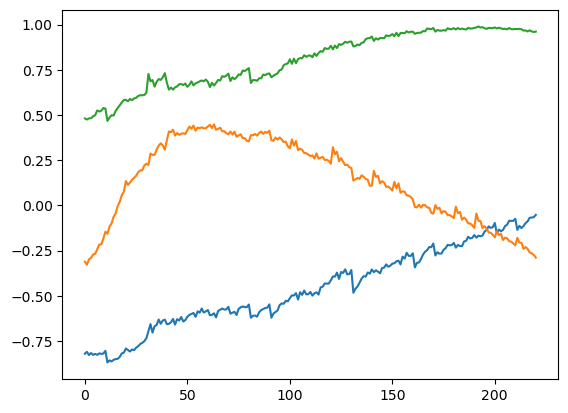

| iter   8000 | 38.51 sec | train loss    0.015 
| iter   8000 | validation loss:    0.021 


Output()

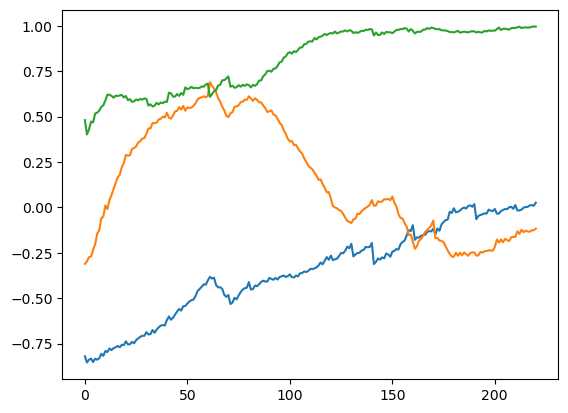

| iter  12000 | 39.08 sec | train loss    0.010 
| iter  12000 | validation loss:    0.009 


Output()

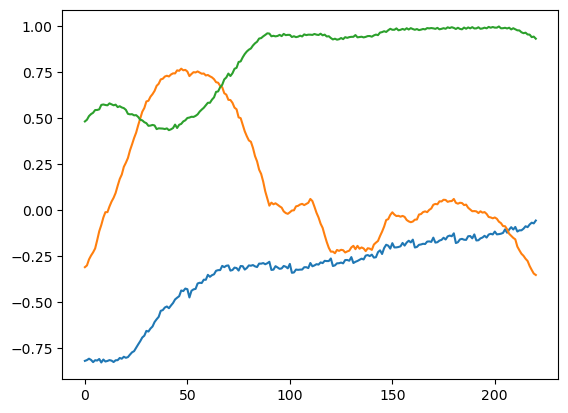

| iter  16000 | 39.62 sec | train loss    0.006 
| iter  16000 | validation loss:    0.008 


Output()

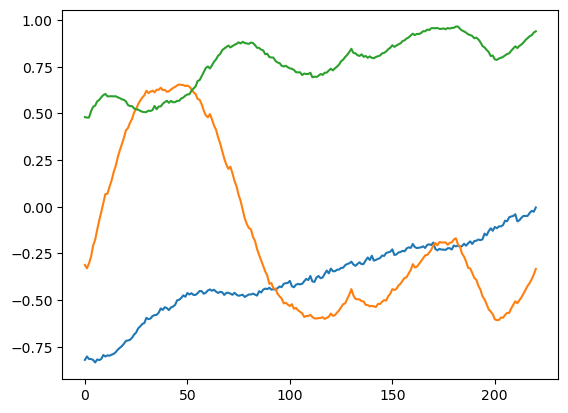

| iter  20000 | 38.84 sec | train loss    0.005 
| iter  20000 | validation loss:    0.009 


Output()

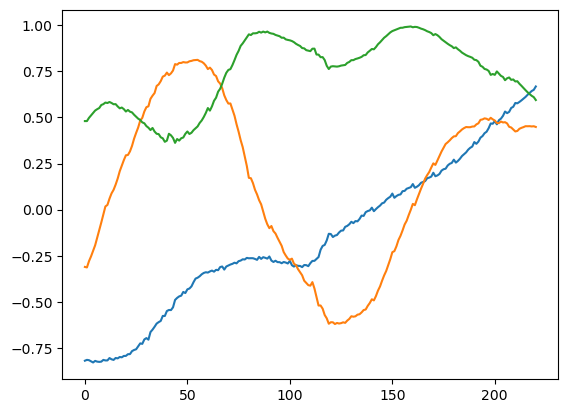

| iter  24000 | 37.75 sec | train loss    0.004 
| iter  24000 | validation loss:    0.008 


Output()

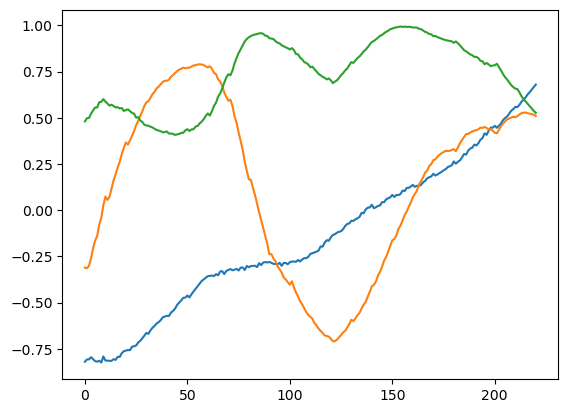

| iter  28000 | 37.67 sec | train loss    0.004 
| iter  28000 | validation loss:    0.004 


Output()

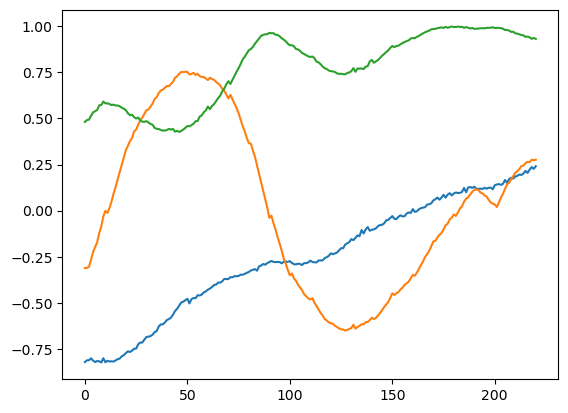

| iter  32000 | 39.48 sec | train loss    0.003 
| iter  32000 | validation loss:    0.002 


Output()

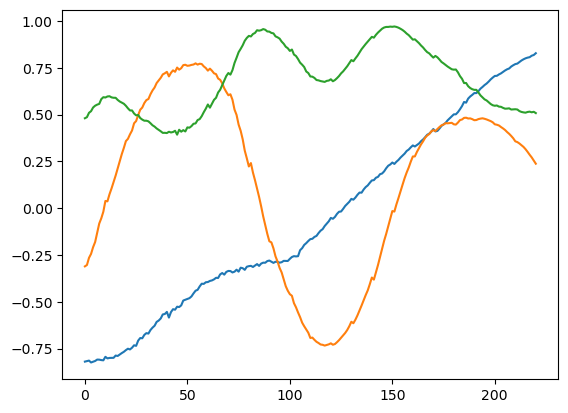

KeyboardInterrupt: 

In [12]:
run_train(vf=vf, 
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            run_parameters=run_parameters, 
            manifold=manifold, 
            ema_vf=ema_vf, dataset=dataset, 
            gt_obs=gt_obs, 
            run_name="sine_tangent_S2")

In [34]:
vf = get_model("sine_tangent_S2")

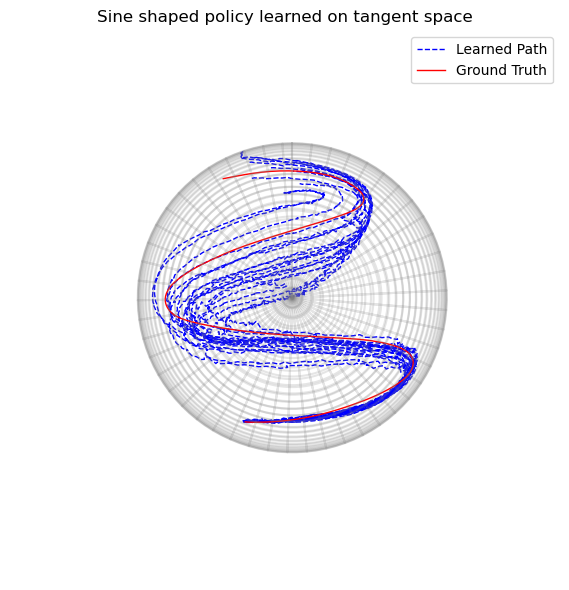

In [35]:
class_labels = dataset.get_label_maping()
for label_name in list(class_labels.keys()):
    results = []
    samples = []
    errors = []
    for _ in range(20): #run_parameters['train']['inf_runs_num']):
        label = torch.tensor(class_labels[label_name],dtype=torch.long).unsqueeze(0)
        res, samp = infer_model_tangent(
                                        model=vf, 
                                        start=gt_obs[class_labels[label_name],0,:run_parameters['data']['dim']], 
                                        label=label,
                                        dim_manifold=run_parameters['data']['dim'],
                                        model_horizon=run_parameters['data']['horizon_size'],
                                        inference_horizon=run_parameters['data']['inference_horizon'],
                                        sample_points=240,
                                        mean=run_parameters['data']['mean'],
                                        std=run_parameters['data']['std'],
                                        step_size=0.05
                                    )
        results.append(Sphere().projx(Sphere().expmap(gt_obs[0, 0, :3], res)))
        samples.append(Sphere().projx(samp))
        
    plot_flow_on_sphere(results, 
                        samples_list=samples, 
                        gt_samples=gt_obs[class_labels[label_name]], 
                        label=label_name, 
                        dynamic=False, one_canvas=True, plot_samples=False, line_type='--', axis_off=True, title="Sine shaped policy learned on tangent space")

In [32]:
dtw = []
for i in range(len(results)):
    dtw.append(dtw_distance(results[i], gt_obs[0,:,:3], dist_func=spherical_distance))

In [33]:
dtw = np.array(dtw)
print(dtw.mean(), dtw.std())

32.104496 15.119566


In [44]:
def calculate_MSE_uncertainty(model, gt_obs, num_samples, run_parameters, base):
    len_gt = gt_obs.size(1)
    errors = []
    gt = gt_obs[0, :, :3]
    class_labels = dataset.get_label_maping()
    for label_name in list(class_labels.keys()):
        label = torch.tensor(class_labels[label_name],dtype=torch.long).unsqueeze(0)
        for i in tqdm(range(num_samples), desc="Evaluating model", leave=False):
            idx = torch.randint(0, len_gt, (1,))
            c, tau_minus_c = sample_context(idx=idx, sample_points=len_gt)
            context = [gt[idx].squeeze(), gt[c].squeeze(), tau_minus_c[0]]
            if base == "S":
                context = torch.cat(context).unsqueeze(0)
                wrapped_vf = WrappedVF(model=ProjectToTangent(vecfield=model, 
                                                            manifold=Sphere()),
                                        obs=context,
                                        label=label)
                wrapped_vf.eval()

                a0 = sample_normal_source(dim=run_parameters['data']['dim']-1,
                                        horizon=run_parameters['data']['horizon_size'], 
                                        manifold=Sphere(), 
                                        mean=run_parameters['data']['mean'],
                                        std=run_parameters['data']['std'],
                                        dim_to=run_parameters['data']['dim'])
                
                solver = RiemannianODESolver(velocity_model=wrapped_vf, 
                                            manifold=Sphere())
            elif base=="Tangent":
                context[0] = Sphere().logmap(gt_obs[0, 0, :3], context[0])
                context[1] = Sphere().logmap(gt_obs[0, 0, :3], context[1])
                context = torch.cat(context).unsqueeze(0)
                wrapped_vf = WrappedVF(model=ProjectToTangent(vecfield=model, 
                                                            manifold=Euclidean()),
                                        obs=context,
                                        label=label)
                wrapped_vf.eval()

                a0 = sample_normal_source(dim=run_parameters['data']['dim'],
                                        horizon=run_parameters['data']['horizon_size'], 
                                        manifold=None, 
                                        mean=run_parameters['data']['mean'],
                                        std=run_parameters['data']['std'],
                                        dim_to=run_parameters['data']['dim'])
                a0 = manifold.proju(gt_obs[0, 0, :3], a0)
                
                solver = RiemannianODESolver(velocity_model=wrapped_vf, 
                                            manifold=Euclidean())
                
            T = torch.tensor([0.0,1.0])
            path_sample = solver.sample(
                            x_init=a0,
                            step_size=0.05,
                            method="midpoint",
                            return_intermediates=False,
                            verbose=False,
                            time_grid = T,
                        )
            infered_data = path_sample.squeeze().clone()
            val = gt[idx+1:idx+1+run_parameters['data']['horizon_size']]
            infered_data = infered_data[:val.size(0)]
            if base=="Tangent":
                infered_data = Sphere().projx(Sphere().expmap(gt_obs[0, 0, :3], infered_data))
            errors.append(geodesic_mse(infered_data, val))
        return errors

In [45]:
errors = np.array(calculate_MSE_uncertainty(model=vf,
                          gt_obs=gt_obs,
                          num_samples=1000,
                          run_parameters=run_parameters,
                          base='Tangent'))

In [46]:
print(errors[~np.isnan(errors)].mean(), errors[~np.isnan(errors)].std())

0.018871102 0.033745706
